## Imports

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import sys, logging

logging.basicConfig(
        level=logging.INFO,
        stream=sys.stdout,
        format="[%(asctime)s] {%(pathname)s:%(lineno)d} %(levelname)s - %(message)s",
        force=True,
    )

In [3]:
import gc

from scipy.stats import norm
import math

import numpy as np
import pandas as pd
import torch


from tqdm import tqdm
import time

In [4]:
if torch.cuda.is_available():
    torch.set_default_tensor_type("torch.cuda.FloatTensor")
    # torch.set_default_tensor_type("torch.cuda.DoubleTensor")
    device = "cuda"

else:
    torch.set_default_tensor_type("torch.FloatTensor")
    device = "cpu"

/home/kusmierc/bnn-from-gp/bnngp/.env/lib/python3.9/site-packages/torch/__init__.py:955: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)


In [5]:
# torch.set_default_tensor_type("torch.FloatTensor")
# device = "cpu"

In [6]:
print(f"Used device = {device}")

Used device = cuda


In [7]:
sys.path.append("../")

import reparameterized
from reparameterized import sampling

In [8]:
from data.minibatches import generate_minibatches, iterate_over_minibatches
from aux.gpu import gpu_memory_info_smi

import import_export

ERROR: Failed to import from rational.torch: No module named 'rational'


## Config

In [9]:
import args as args_loading

# used when run from command line
args = args_loading.parse_args()
# print(f"Parsing args = {args}")

In [10]:
random_seed = args.get("random_seed", 0)

In [11]:
train_data_proportion = args.get("train_data_proportion", 6 / 9)


# NF 
nf_model = args.get("nf_model", 0) 
realnvp_rezero = args.get("realnvp_rezero", False)
realnvp_num_layers = args.get("realnvp_num_layers", 32)
realnvp_m_multiplier = args.get("realnvp_m_multiplier", 6)

# NF posterior training
stl_gradient_estimator = False
n_epochs = args.get("n_epochs", 1000)
batch_size = args.get("batch_size", 1024*10)
n_posterior_samples_total = args.get("n_posterior_samples_total", 128)

optimizer = args.get("optimizer", "adam")
optimizer_lr = args.get("optimizer_lr", 0.001)
early_stopping_n_iters = args.get("early_stopping_n_iters", 100)

beta = args.get("beta", 0.4)
beta_annealing = args.get("beta_annealing", False)
beta_annealing_iterations = args.get("beta_annealing_iterations", 200)

report_every_n_iterations = args.get("report_every_n_iterations", 200)
eval_n_samples = args.get("eval_n_samples", 1024)

In [12]:
observation_noise_scale = args.get("observation_noise_scale", 0.1)
learn_observation_noise_scale = args.get("learn_observation_noise_scale", False)


prior_fit_result = args.get("prior", 
    "../results/experiment_house_electric_fit_prior_varying_lengthscales_20250116183912/house_electric_ls1_nnsilu_s1_results.json.gz"
    # "../results/experiment_house_electric_fit_prior_varying_lengthscales_20250116183912/house_electric_ls1_fourier2_s0_results.json.gz"
    )

datafile = "../data/uci_household_power_consumption/individual+household+electric+power+consumption.npy"

In [13]:
output_prefix = args.get("run_name", "house_electric_fit_posterior_vi")+"_"

In [14]:
# args["smoke_test"] = True

In [15]:
if args.get("smoke_test", False):
    nf_model = 1
    n_epochs = 4
    report_every_n_iterations = 2
    n_posterior_samples_total = 3
    eval_n_samples = 12
    batch_size = 1024*10

In [16]:
print(f"Configuration = {locals()}")

Configuration = {'__name__': '__main__', '__doc__': 'Automatically created module for IPython interactive environment', '__package__': None, '__loader__': None, '__spec__': None, '__builtin__': <module 'builtins' (built-in)>, '__builtins__': <module 'builtins' (built-in)>, '_ih': ['', "get_ipython().run_line_magic('reload_ext', 'autoreload')\nget_ipython().run_line_magic('autoreload', '2')", 'import sys, logging\n\nlogging.basicConfig(\n        level=logging.INFO,\n        stream=sys.stdout,\n        format="[%(asctime)s] {%(pathname)s:%(lineno)d} %(levelname)s - %(message)s",\n        force=True,\n    )', 'import gc\n\nfrom scipy.stats import norm\nimport math\n\nimport numpy as np\nimport pandas as pd\nimport torch\n\n\nfrom tqdm import tqdm\nimport time', 'if torch.cuda.is_available():\n    torch.set_default_tensor_type("torch.cuda.FloatTensor")\n    # torch.set_default_tensor_type("torch.cuda.DoubleTensor")\n    device = "cuda"\n\nelse:\n    torch.set_default_tensor_type("torch.Flo

## Load and preprocess data.

In [17]:
from data.uci_household_power_consumption import load as data_src

In [18]:
(
    x_train,
    y_train,
    x_test,
    y_test,
    y_train_r_mean,
    y_train_r_std,
    tt_split_hsh,
) = data_src.prepare_data(datafile=datafile, train_prop=train_data_proportion)
print("data", x_train.shape, y_train.shape, x_test.shape, y_test.shape, y_train_r_mean, y_train_r_std, tt_split_hsh)

data torch.Size([1366186, 8]) torch.Size([1366186]) torch.Size([683094, 8]) torch.Size([683094]) tensor(9.3178) tensor(9.5873) 9d025f6b9a0637a8e6858f9ad33f3a12


In [19]:
# Data to torch tensors for training
training_data = x_train
training_targets = y_train

train_x = training_data.to(device)
train_y = training_targets.to(device)
x_test =  x_test.to(device)
y_test =  y_test.to(device)

In [20]:
gc.collect()
gpu_memory_info_smi()

[2025-01-27 18:17:35,697] {/home/kusmierc/bnn-from-gp/bnngp/notebooks/../aux/gpu.py:59} INFO - [gpu_memory_info_smi] GPU 0: Total Memory: 10240 MiB, Used: 508 MiB, Free: 9500 MiB


## BNN

In [21]:
if learn_observation_noise_scale:
    observation_noise_scale = torch.tensor(observation_noise_scale, requires_grad=True)

In [22]:
def log_likelihood(bnn, train_x, train_y, observation_noise_scale):
    pred_means = bnn(train_x)
    log_probs = torch.distributions.Normal(
        pred_means.flatten(), observation_noise_scale
    ).log_prob(train_y.flatten())
    return log_probs

In [23]:
import import_export 

prior_params = import_export.load_from_json(prior_fit_result)
activation = prior_params["parameters"]["activation"].to(device)
net_width = prior_params["net_width"]

prior_params["parameters"].pop("activation")
priors = prior_params["parameters"]

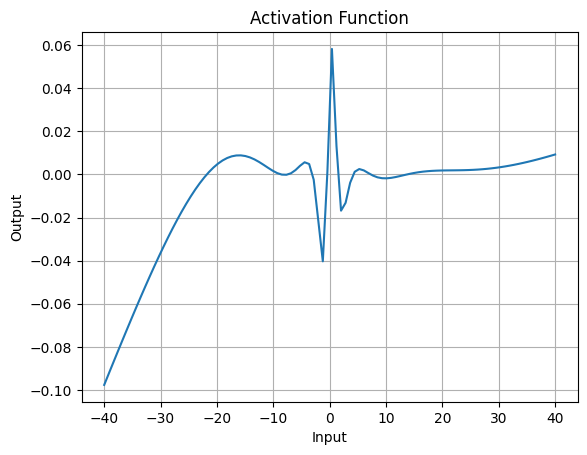

In [24]:
try:
    from matplotlib import pyplot as plt

    x = torch.linspace(-40, 40, 100)
    y = activation(x).detach().cpu().numpy()

    plt.plot(x.detach().cpu().numpy(), y)
    plt.title("Activation Function")
    plt.xlabel("Input")
    plt.ylabel("Output")
    plt.grid(True)
    plt.show()
except Exception as e:
    print(e)

In [25]:
for name, param in activation.named_parameters():
    print(f"turning off gradient for {name}")
    param.requires_grad = False

turning off gradient for fci.weight
turning off gradient for fci.bias
turning off gradient for fc.0.weight
turning off gradient for fc.0.bias
turning off gradient for fco.weight
turning off gradient for fco.bias


In [26]:
print(f"priors = {priors}")

priors = {'layer1.weight': Normal(loc: 0.0, scale: 0.4770457148551941), 'layer1.bias': Normal(loc: 0.0, scale: 0.10911737382411957), 'layer2.weight': Normal(loc: 0.0, scale: 1.5432627201080322), 'layer2.bias': Normal(loc: 0.0, scale: 0.07194221764802933)}


In [27]:
def log_priors(priors, samples):
    return sum(priors[n].log_prob(p.flatten()).sum() for n, p in samples.items())  # sum over all parameters

### Evaluation

In [28]:
def sample_from_predictive(
    bnn,
    sampler,
    x,
    n_samples=1024,
    n_samples_per_sampling=128,
    batch_size=1024,
    verbose=False,
    **kwargs,
):
    """ Generate n_samples of prediction means using the sampler function."""
    
    n_samples_per_sampling = min(n_samples_per_sampling, n_samples)
    assert (
        n_samples % n_samples_per_sampling == 0
    ), "n_samples_per_sampling must divide n_samples"

    preds = []
    progress_tracking = lambda i: i
    if verbose:
        logging.info(
            f"[get_predicitive] generating n_samples={n_samples} "
            f"n_samples_per_sampling={n_samples_per_sampling} "
            f"minibatch_size={batch_size}"
        )
        progress_tracking = tqdm
    for _ in progress_tracking(range(n_samples // n_samples_per_sampling)):
        samples, _ = sampler(n_samples_per_sampling)

        for s in reparameterized.take_parameters_sample(samples):
            reparameterized.load_state_dict(bnn, s)

            pred = []
            for x1 in iterate_over_minibatches(x, batch_size=batch_size):
                pred1 = bnn(x1)
                pred.append(pred1)
            pred = torch.concat(pred)

            preds.append(pred)

    preds = torch.stack(preds)[:, :, 0]
    assert preds.shape == torch.Size(
        [n_samples, x.shape[0]]
    ), f"preds.shape={preds.shape} vs {n_samples, x.shape[0]}"

    return preds

In [29]:
@torch.no_grad()
def negative_log_likelihood(train_y, mu_samples, observation_noise_scale, agg=None):
    """Calculate the negative log likelihood for the given dataset."""
    n_samples = mu_samples.size(0)
    n_train = train_y.size(0)
    
    # Create a normal distribution with the given mean and observation noise
    d = torch.distributions.Normal(mu_samples, observation_noise_scale)
    
    # Compute the log probabilities of the training data under this distribution
    log_probs = d.log_prob(train_y.unsqueeze(0).expand(n_samples, n_train))
    
    # Average the log probabilities over the samples
    avg_log_probs = torch.logsumexp(log_probs, dim=0) - math.log(n_samples)
    
    # Sum the -log probabilities to get the negative log likelihood
    return -avg_log_probs if agg is None else agg(-avg_log_probs)


@torch.no_grad()
def negative_log_likelihood_gaussian(train_y, mu_samples, observation_noise_scale, agg=None):
    """Calculates the negative log likelihood of Gaussian distribution."""
    
    y, mu, var = train_y, mu_samples.mean(0), mu_samples.var(0)+observation_noise_scale**2
    
    y, mu, var = y.squeeze(), mu.squeeze(), var.squeeze()
    nll = -norm.logpdf(y.cpu().detach(), loc=mu.cpu().detach(), scale=np.sqrt(var.cpu().detach()))

    return torch.tensor(nll) if agg is None else agg(nll)

In [30]:
@torch.no_grad()
def eval_bnn(x_test, y_test, bnn, sampler, observation_noise_scale, **kwargs):
    gc.collect()

    pred_mean_samples = sample_from_predictive(bnn, sampler, x_test, **kwargs)
    gc.collect()

    nlls = []
    nlls_g = []
    data_size = len(y_test)
    for pred_mean_samples1, y_test1 in iterate_over_minibatches(
        pred_mean_samples.T, y_test, 10 * 1024
    ):
        pred_mean_samples1 = pred_mean_samples1.T
        
        nll = negative_log_likelihood(y_test1.flatten(), pred_mean_samples1, observation_noise_scale)
        nlls.append(nll)
                                
        nll_g = negative_log_likelihood_gaussian(y_test1.flatten(), pred_mean_samples1, observation_noise_scale)
        nlls_g.append(nll_g)

    nlls_g = torch.cat(nlls_g)
    assert nlls_g.shape == torch.Size([data_size])
    nll_g = nlls_g.mean()  # average over data points

    nlls = torch.cat(nlls)
    assert nlls.shape == torch.Size([data_size])        
    nll = nlls.mean()  # average over data points

    preds_avg_mean = pred_mean_samples.mean(axis=0)
    rmse = torch.sqrt(((preds_avg_mean - y_test) ** 2).mean())

    gc.collect()
    return {"rmse": rmse.item(), "nll_g": nll_g.item(), "nll": nll.item()}

### Network

In [31]:
# Network
class SingleHiddenLayerWideNN(torch.nn.Module):
    def __init__(self, width=1000, indim=1, outdim=1, activation=None):
        super().__init__()
        self.width = width
        self.layer1 = torch.nn.Linear(indim, width)
        self.layer2 = torch.nn.Linear(width, outdim)
        self.activation = activation

    def forward(self, x, learnable_activation=None):
        learnable_activation = self.activation or learnable_activation

        x = self.layer1(x)
        x = learnable_activation(x)
        x = self.layer2(x)
        return x

In [32]:
indim = x_train.shape[-1]

bnn = SingleHiddenLayerWideNN(indim=indim, width=net_width, activation=activation)
print(bnn)

SingleHiddenLayerWideNN(
  (layer1): Linear(in_features=8, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=1, bias=True)
  (activation): NNActivation(
    (activation): SiLU()
    (fci): Linear(in_features=1, out_features=5, bias=True)
    (fc): Sequential(
      (0): Linear(in_features=5, out_features=5, bias=True)
    )
    (fco): Linear(in_features=5, out_features=1, bias=True)
  )
)


### Posterior Sampler = Normalizing Flow

In [33]:
torch.manual_seed(random_seed)

In [34]:
bnn_learning_params = {n: p for n,p in bnn.named_parameters() if "activation" not in n}  # exclude activation params
print(f"bnn_learning_params = {bnn_learning_params.keys()}")

bnn_learning_params = dict_keys(['layer1.weight', 'layer1.bias', 'layer2.weight', 'layer2.bias'])


In [35]:
if nf_model==0:
    sampler, variational_params, aux_objs = sampling.create_multiparameter_sampler_dict(
        sampling.create_flow_sampler,
        bnn_learning_params,
        build_flow_func = sampling.realnvp.build_realnvp,
        realnvp_rezero=realnvp_rezero,
        realnvp_num_layers=realnvp_num_layers,
        realnvp_m=int(realnvp_m_multiplier*net_width),
        )
    n_posterior_samples = n_posterior_samples_total  # in one forward operation
    
elif nf_model==1:
    sampler, variational_params, aux_objs = sampling.create_multiparameter_sampler_dict(
        sampling.create_flow_sampler,
        bnn_learning_params,
        build_flow_func = sampling.realnvp.build_realnvp,
        realnvp_rezero=realnvp_rezero,
        realnvp_num_layers=2,
        realnvp_m=32,
        )
    n_posterior_samples = n_posterior_samples_total  # in one forward operation
    
    
else:
    raise ValueError(f"Wrong value of nf_model={nf_model}!")

In [36]:
print("flow=", aux_objs["flow"])

flow= RealNVP(
  (t): ModuleList(
    (0-1): 2 x Sequential(
      (0): Linear(in_features=641, out_features=32, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=32, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=640, bias=True)
    )
  )
  (s): ModuleList(
    (0-1): 2 x Sequential(
      (0): Linear(in_features=641, out_features=32, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=32, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=640, bias=True)
      (5): Tanh()
    )
  )
)


In [37]:
gpu_memory_info_smi()

[2025-01-27 18:17:38,613] {/home/kusmierc/bnn-from-gp/bnngp/notebooks/../aux/gpu.py:59} INFO - [gpu_memory_info_smi] GPU 0: Total Memory: 10240 MiB, Used: 550 MiB, Free: 9458 MiB


In [38]:
start_time = time.time()
samples, q_nlls = sampler(1)
print(f"sampled 1 sample in {time.time()-start_time: .2f}s")

s1 = next(reparameterized.take_parameters_sample(samples))
n_parameters = sum(s.numel() for s in s1.values())
print(f"n_parameters = {n_parameters}")

n_variational_params = sum(p.numel() for p in variational_params.values())
print(f"n_variational_params = {n_variational_params}")

sampled 1 sample in  0.15s
n_parameters = 1281
n_variational_params = 170880


In [39]:
print("samples=", samples, "q_nlls=", q_nlls)

samples= {'layer1.weight': tensor([[[-0.8969,  1.1240,  2.7709,  ..., -0.3293, -1.0415, -0.7757],
         [-0.5347, -0.6538, -0.9425,  ...,  0.2962,  1.6913,  1.0320],
         [ 1.6295,  2.0771, -0.7510,  ...,  0.4557,  0.2408, -1.3693],
         ...,
         [ 0.8948,  0.7201,  0.8651,  ..., -0.6070,  0.6629, -0.7956],
         [ 0.4405, -1.0280,  0.5489,  ..., -0.5298,  0.2224, -1.4329],
         [-0.8330,  0.0102,  0.3885,  ..., -1.3906, -1.4269,  2.4943]]],
       grad_fn=<ViewBackward0>), 'layer1.bias': tensor([[ 1.3380, -0.2402, -0.4335,  1.1140, -0.5176, -0.4133,  0.0951, -0.4121,
          1.1289, -1.2984, -0.4001, -0.4176, -0.5007, -0.3035,  1.2628, -0.4590,
         -1.0774,  2.1742,  1.9130, -0.3481,  0.7011,  0.4887,  1.8415, -0.3275,
          0.2887, -0.7674, -0.9787, -0.9320,  0.0723,  0.7709,  2.6389, -1.6853,
         -0.9787,  0.9988,  1.5123, -0.9125, -0.2764, -1.3456,  0.1131, -1.0530,
          0.5553,  1.3628, -1.4490, -1.7397, -0.3691,  1.3694, -0.3849, -0.326

In [40]:
print(f"Using device: samples={next(iter(samples.values())).device} train_x={train_x.device}")

Using device: samples=cuda:0 train_x=cuda:0


In [41]:
gc.collect()
gpu_memory_info_smi()

[2025-01-27 18:17:39,222] {/home/kusmierc/bnn-from-gp/bnngp/notebooks/../aux/gpu.py:59} INFO - [gpu_memory_info_smi] GPU 0: Total Memory: 10240 MiB, Used: 550 MiB, Free: 9458 MiB


In [42]:
# start_time = time.time()
# n_samples = 20
# samples, q_nlls = sampler(n_samples)
# print(f"sampled {n_samples} samples in {time.time()-start_time: .2f}s")

#### Training ELBO

In [43]:
eval_stats = eval_bnn(
    x_test,
    y_test,
    bnn,
    sampler,
    n_samples=eval_n_samples,
    observation_noise_scale=observation_noise_scale,
    verbose=True,
)
eval_stats_str = " ".join(f"{n}: {v:.4f}" for n, v in eval_stats.items())
logging.info(f"Before traininging: {eval_stats_str}")
gc.collect()
gpu_memory_info_smi()

[2025-01-27 18:17:39,484] {/tmp/ipykernel_1578376/3923916588.py:21} INFO - [get_predicitive] generating n_samples=12 n_samples_per_sampling=12 minibatch_size=1024


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


[2025-01-27 18:17:41,492] {/tmp/ipykernel_1578376/3150869581.py:11} INFO - Before traininging: rmse: 1.2783 nll_g: 1.6789 nll: 7.0422


/tmp/ipykernel_1578376/2848490842.py:27: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  nll = -norm.logpdf(y.cpu().detach(), loc=mu.cpu().detach(), scale=np.sqrt(var.cpu().detach()))


[2025-01-27 18:17:41,659] {/home/kusmierc/bnn-from-gp/bnngp/notebooks/../aux/gpu.py:59} INFO - [gpu_memory_info_smi] GPU 0: Total Memory: 10240 MiB, Used: 562 MiB, Free: 9446 MiB


In [44]:
def pick_optimizer(opt, *args, **kwargs):
    optimizers = {
        'sgd': torch.optim.SGD(*args, **kwargs),
        'asgd': torch.optim.ASGD(*args, **kwargs),
        'adam': torch.optim.Adam(*args, **kwargs),
        'adamw': torch.optim.AdamW(*args, **kwargs),
        'adamax': torch.optim.Adamax(*args, **kwargs),
        'rms': torch.optim.RMSprop(*args, **kwargs),
        'rprop': torch.optim.Rprop(*args, **kwargs),
        # 'adah': AdaHessian(*args, **kwargs)
    }
    return optimizers[opt]

In [45]:
optimized_parameters = list(variational_params.values())
if learn_observation_noise_scale:
    optimized_parameters += [observation_noise_scale]
optimizer = pick_optimizer(optimizer, optimized_parameters, lr=optimizer_lr)

assert (
    n_posterior_samples_total % n_posterior_samples == 0
), "n_posterior_samples must divide n_posterior_samples_total"

start_time = time.time()
history = [{"epoch": -1, "time": 0}]
for n, v in eval_stats.items():
    history[-1][f"test_{n}"] = v    
best_loss, best_it = (
    float("inf"),
    -early_stopping_n_iters,
)  # early stopping initialization
beta_max = beta
for it in tqdm(range(n_epochs)):
    ###################################################################################################

    KLDs, log_liks, losses = [], [], []
    for minibatch_no, (minibatch_x, minibatch_y) in enumerate(
        generate_minibatches(
            train_x,
            train_y,
            batch_size=batch_size,
            shuffle=True,
            last_batch_size_required=0.6,
        )
    ):  ###################################################################################################
        # print(f"[{time.time()-start_time:.1f}] next minibatch of size = {len(minibatch_x)}")
        # gc.collect()
        optimizer.zero_grad()

        if beta_annealing:
            beta = np.min([beta_max, 0.001 + it / beta_annealing_iterations])

        loss_vi = 0.0
        for s in range(
            n_posterior_samples_total // n_posterior_samples
        ):  # gradient accumulation steps
            #################################################################################################
            # print(f"[{time.time()-start_time:.1f}] epoch={it} accumulating_step={s}")

            samples, q_nlls = sampler(n_samples=n_posterior_samples)
            # assert not q_nlls.isnan().any(), q_nlls

            # Apply `stop_gradient` to q_nlls to eliminate the score function term
            if stl_gradient_estimator:  # @TODO - check if this is correct
                with torch.no_grad():
                    q_nlls = q_nlls.clone().detach()

            p_nlls = [
                -log_priors(priors, s)
                for s in reparameterized.take_parameters_sample(samples)
            ]
            p_nlls = torch.stack(p_nlls)

            assert p_nlls.shape == q_nlls.shape
            KLD = p_nlls - q_nlls
            KLD = KLD.sum() / n_posterior_samples  # average over n_posterior_samples

            log_lik = 0.0
            for i, s in enumerate(reparameterized.take_parameters_sample(samples)):
                # if i==0 or i==99:
                #     print(f"[{time.time()-start_time:.1f}] sample={i} bnn={bnn.layer1.weight.device} minibatch_x={minibatch_x.device}")
                reparameterized.load_state_dict(bnn, s)
                ll = log_likelihood(
                    bnn,
                    minibatch_x,
                    minibatch_y,
                    observation_noise_scale=observation_noise_scale,
                )
                log_lik += ll.sum()  # sum over data
            log_lik /= n_posterior_samples  # average over n_posterior_samples

            loss_vi += -(log_lik - beta * KLD)

            KLDs.append(KLD.detach().cpu().item())
            log_liks.append(log_lik.detach().cpu().item())
            losses.append(loss_vi.detach().cpu().item())
        # /FOR POSTERIOR SAMPLES ###########################################################################

        # print(f"[{time.time()-start_time:.1f}] backward step")
        loss_vi.backward()
        optimizer.step()
    # /FOR MINIBATCH ###########################################################################

    history.append(
        {
            "epoch": it,
            "time": time.time() - start_time,
            "train_log_lik": np.mean(log_liks),
            "train_kld": np.mean(KLDs),
            "train_loss": np.mean(losses),
            "beta": beta,
            "batch_size": batch_size,
            "n_posterior_samples_total": n_posterior_samples_total,
            "minibatch_no": minibatch_no,
            "observation_noise_scale": float(observation_noise_scale),
        }
    )

    gc.collect()

    # early stopping
    improvement = False
    if not beta_annealing or it > beta_annealing_iterations:
        loss = np.mean(losses)
        if loss < best_loss:
            best_loss, best_it = loss, it
            improvement = True

        if it > best_it + early_stopping_n_iters:
            logging.info(
                f"[train_nfm] Early stopping due to no improvement in {early_stopping_n_iters} iterations. "
                f"best_loss={best_loss}, current loss={loss}."
            )
            break

    # reporting
    if (
        (it < 100 and it % 10 == 0)
        or (it > early_stopping_n_iters // 4 and improvement)
        or it % report_every_n_iterations == 0
    ):
        log_lik, KLD, loss = np.mean(log_liks), np.mean(KLDs), np.mean(losses)
        res_str = f"loss={loss: .2f} (log_lik={log_lik: .2f} KLD={KLD: .2f})"
        eval_stats = eval_bnn(
            x_test,
            y_test,
            bnn,
            sampler,
            n_samples=eval_n_samples,
            observation_noise_scale=observation_noise_scale,
        )
        eval_stats_str = " ".join(f"{n}: {v:.4f}" for n, v in eval_stats.items())
        logging.info(
            f"[{time.time()-start_time: .0f}s] epoch={it}: {res_str}  test: {eval_stats_str}  obs_noise: {float(observation_noise_scale):.3f}"
        )

        history[-1]["train_log_lik"] = log_lik
        history[-1]["train_kld"] = KLD
        history[-1]["train_loss"] = loss
        for n, v in eval_stats.items():
            history[-1][f"test_{n}"] = v    
    
        pd.DataFrame(history).to_csv(
            output_prefix + "results.csv", index=False, header=True, sep=","
        )

        gpu_memory_info_smi()

  0%|          | 0/4 [00:00<?, ?it/s]

[2025-01-27 18:17:47,712] {/home/kusmierc/bnn-from-gp/bnngp/notebooks/../data/minibatches.py:51} INFO - [generate_minibatches] Dropping batch of size=4266 (min required=6144)! 
[2025-01-27 18:17:49,905] {/tmp/ipykernel_1578376/3615354928.py:139} INFO - [ 7s] epoch=0: loss= 751551.44 (log_lik=-747746.96 KLD= 9511.18)  test: rmse: 1.0297 nll_g: 1.8813 nll: 21.7333  obs_noise: 0.100


/tmp/ipykernel_1578376/2848490842.py:27: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  nll = -norm.logpdf(y.cpu().detach(), loc=mu.cpu().detach(), scale=np.sqrt(var.cpu().detach()))


[2025-01-27 18:17:49,985] {/home/kusmierc/bnn-from-gp/bnngp/notebooks/../aux/gpu.py:59} INFO - [gpu_memory_info_smi] GPU 0: Total Memory: 10240 MiB, Used: 676 MiB, Free: 9332 MiB


 25%|██▌       | 1/4 [00:07<00:22,  7.44s/it]

[2025-01-27 18:17:55,130] {/home/kusmierc/bnn-from-gp/bnngp/notebooks/../data/minibatches.py:51} INFO - [generate_minibatches] Dropping batch of size=4266 (min required=6144)! 


 50%|█████     | 2/4 [00:12<00:12,  6.22s/it]

[2025-01-27 18:18:00,585] {/home/kusmierc/bnn-from-gp/bnngp/notebooks/../data/minibatches.py:51} INFO - [generate_minibatches] Dropping batch of size=4266 (min required=6144)! 
[2025-01-27 18:18:02,708] {/tmp/ipykernel_1578376/3615354928.py:139} INFO - [ 20s] epoch=2: loss= 575468.55 (log_lik=-571504.49 KLD= 9910.15)  test: rmse: 1.0032 nll_g: 4.0328 nll: 30.5949  obs_noise: 0.100


/tmp/ipykernel_1578376/2848490842.py:27: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  nll = -norm.logpdf(y.cpu().detach(), loc=mu.cpu().detach(), scale=np.sqrt(var.cpu().detach()))


[2025-01-27 18:18:02,786] {/home/kusmierc/bnn-from-gp/bnngp/notebooks/../aux/gpu.py:59} INFO - [gpu_memory_info_smi] GPU 0: Total Memory: 10240 MiB, Used: 676 MiB, Free: 9332 MiB


 75%|███████▌  | 3/4 [00:20<00:06,  6.78s/it]

[2025-01-27 18:18:08,102] {/home/kusmierc/bnn-from-gp/bnngp/notebooks/../data/minibatches.py:51} INFO - [generate_minibatches] Dropping batch of size=4266 (min required=6144)! 


100%|██████████| 4/4 [00:25<00:00,  6.47s/it]


In [46]:
eval_stats = eval_bnn(
    x_test,
    y_test,
    bnn,
    sampler,
    n_samples=eval_n_samples,
    observation_noise_scale=observation_noise_scale,
    verbose=True,
)
eval_stats_str = " ".join(f"{n}: {v:.4f}" for n, v in eval_stats.items())
logging.info(f"Final after training: {eval_stats_str}")

history.append({"epoch": n_epochs, "time": float("inf")})
for n, v in eval_stats.items():
    history[-1][f"test_{n}"] = v    

pd.DataFrame(history).to_csv(
    output_prefix + "results.csv", index=False, header=True, sep=","
)

[2025-01-27 18:18:09,788] {/tmp/ipykernel_1578376/3923916588.py:21} INFO - [get_predicitive] generating n_samples=12 n_samples_per_sampling=12 minibatch_size=1024


100%|██████████| 1/1 [00:01<00:00,  1.56s/it]
/tmp/ipykernel_1578376/2848490842.py:27: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  nll = -norm.logpdf(y.cpu().detach(), loc=mu.cpu().detach(), scale=np.sqrt(var.cpu().detach()))


[2025-01-27 18:18:11,663] {/tmp/ipykernel_1578376/3385917661.py:11} INFO - Final after training: rmse: 0.8036 nll_g: 2.8208 nll: 17.6617


In [47]:
logging.info(f"Storing fit to {output_prefix}results.json")
_ = import_export.save_data_to_json(
    output_prefix + "results.json",
    results={
        "sampler": sampler,
        "variational_params": variational_params,
        "aux_objs": aux_objs,
        "observation_noise_scale": observation_noise_scale,
    },
)

[2025-01-27 18:18:11,719] {/tmp/ipykernel_1578376/557769382.py:1} INFO - Storing fit to house_electric_fit_posterior_vi_results.json
[2025-01-27 18:18:11,720] {/home/kusmierc/bnn-from-gp/bnngp/notebooks/../import_export.py:56} INFO - [import_export] Failed to dump <function create_multiparameter_sampler_dict.<locals>._sampler_dict_wrapper at 0x753e6ebf2670> to JSON (Object of type function is not JSON serializable). Pickling instead.
[2025-01-27 18:18:11,721] {/home/kusmierc/bnn-from-gp/bnngp/notebooks/../import_export.py:63} WARNING - [import_export] Failed to pickle <function create_multiparameter_sampler_dict.<locals>._sampler_dict_wrapper at 0x753e6ebf2670> (Can't pickle local object 'create_multiparameter_sampler_dict.<locals>._sampler_dict_wrapper'). The object will not be recoverable.
[2025-01-27 18:18:11,725] {/home/kusmierc/bnn-from-gp/bnngp/notebooks/../import_export.py:56} INFO - [import_export] Failed to dump Parameter containing:
tensor([[-0.0077,  0.0041, -0.0179,  ..., -